#  🤗 Transformers

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://huggingface.co/docs/transformers/index
* https://huggingface.co/docs/transformers/main_classes/pipelines#transformers.pipeline.task
* https://huggingface.co/docs/transformers/preprocessing
* https://huggingface.co/blog/getting-started-with-embeddings
* https://huggingface.co/sentence-transformers
* https://habr.com/ru/articles/704592/

## Задачи для совместного разбора

1\. Обсудите основные возможности и экосистему пакета 🤗 Transformers на примере задачи поиска ответа на вопрос в тексте.

In [ ]:
text = """The seminars on Deep Learning and Natural Language Processing were truly captivating,
providing a deep dive into the intricacies of these disciplines.
The wealth of knowledge and insights gained during the sessions was commendable.
However, it's disheartening to note the scarcity of homework assignments.
Anastasia, in particular, is quite concerned that the limited number of assignments might
fall short of even reaching 30. While the seminars were intellectually stimulating,
the desire for more hands-on practice through assignments remains strong,
as it is crucial for reinforcing the theoretical understanding acquired during the classes."""

In [ ]:
question1 = "What would be the ideal number of homework assignments for Anastasia"
question2 = "What are the shortcomings of the course?"

In [ ]:
import transformers

In [ ]:
from transformers import pipeline

question_answerer = pipeline("question-answering",
                             model='distilbert-base-uncased-distilled-squad')

result = question_answerer(question=question1,
                           context=text)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Answer: '30', score: 0.8874, start: 429, end: 431


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-distilled-squad')
model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased-distilled-squad')

question, text = question1, text

inputs = tokenizer(question, text, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

answer_start_index = torch.argmax(outputs.start_logits)
answer_end_index = torch.argmax(outputs.end_logits)

predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
tokenizer.decode(predict_answer_tokens)

'30'

## Задачи для самостоятельного решения

In [1]:
import re
import json
import pandas as pd
from tqdm import tqdm
import torch as th
import transformers
from transformers import pipeline
from torch.utils.data.dataloader import DataLoader

<p class="task" id="1"></p>

1\. Среди предобученных моделей найдите модель для перевода текста с русского языка на английский. Протестируйте данную модель на нескольких предложениях, используя `transformers.pipeline`. Выведите результаты работы в следующем виде:

```
sentence1_ru -> sentence1_en
sentence2_ru -> sentence2_en
```

Получите перевод для всех текстов из файла `RuBQ_2.0_test.json` и посчитайте BLEU-score.

- [x] Проверено на семинаре

In [ ]:
!pip install sacremoses

In [ ]:
X = []
y = []

with open('RuBQ_2.0_test.json', 'r') as f:
  for dct in json.load(f):
    X.append(re.sub(r'[^a-zа-я ]', '', dct['question_text'].lower()))
    y.append(re.sub(r'[^a-zа-я ]', '', dct['question_eng'].lower()))

len(X), len(y)

(580, 580)

In [ ]:
loader = DataLoader(X, batch_size=16)

In [ ]:
translator = pipeline(
    "translation",
    model='facebook/wmt19-ru-en',
    device='cuda'
)

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

Some weights of FSMTForConditionalGeneration were not initialized from the model checkpoint at facebook/wmt19-ru-en and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

vocab-src.json:   0%|          | 0.00/776k [00:00<?, ?B/s]

vocab-tgt.json:   0%|          | 0.00/639k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/396k [00:00<?, ?B/s]

In [ ]:
result = []
for batch in tqdm(loader, total=len(X) // 16):
  res = [t['translation_text'] for t in translator(batch)]
  result.extend(res)

 28%|██▊       | 10/36 [00:27<01:17,  2.97s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
37it [01:29,  2.43s/it]


In [ ]:
import nltk

hyp = [[text] for text in result]

bleu_score = nltk.translate.bleu_score.corpus_bleu(hyp, y)
print(bleu_score)

0.734034844351371


<p class="task" id="2"></p>

2\. Загрузите данные из файла `reviews_polarity.csv`. Среди предобученных моделей найдите модель для классификации тональности русскоязычного текста (позитивный/негативный или позитивный/негативный/нейтральный). Протестируйте данную модель на нескольких предложениях, используя `transformers.pipeline`. Выведите результаты работы в следующем виде:

```
sentence1 -> class1
sentence2 -> class2
...
```

Получите прогноз для всех текстов из файла и посчитайте F1-score. Для ускорения работы модели вы можете перенести ее на GPU и использовать возможности pipeline для работы с батчами и генераторами.

- [x] Проверено на семинаре

In [ ]:
df = pd.read_csv('reviews_polarity.csv')
df.head(1)

,text,class
0,"Очень хорошо что открылась 5 ка, теперь не над...",1


In [ ]:
sentiment_task = pipeline(
    "sentiment-analysis",
    model='seara/rubert-tiny2-russian-sentiment',
    tokenizer='seara/rubert-tiny2-russian-sentiment',
    device='cuda'
)

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
sentences = df['text'][:3].tolist()
answers = df['class'][:3].tolist()
res = sentiment_task(sentences)
for idx, r in enumerate(res):
  print(f"{sentences[idx]} -> {r['label']}")

Очень хорошо что открылась 5 ка, теперь не надо далеко ехать все рядом! -> positive
Тесно, вечная сутолока, между рядами трудно разойтись, грязно. Была пару раз. Больше не пойду.  -> negative
Магазин в пешей доступности. После ремонта и реконструкции стал намного лучше и уютнее. Радует появившаяся пекарня и выпечка. -> positive


In [ ]:
def replace(lst):
  dct = {
      'positive': 1,
      'negative': 0,
      'neutral': 1
  }
  return [dct[label] for label in lst]

In [ ]:
loader_revs = DataLoader(df['text'], batch_size=16)
res = []

for batch in tqdm(loader_revs, total=len(df['text']) // 16):
  out = sentiment_task(batch)
  res.extend(replace([pred['label'] for pred in out]))

  0%|          | 10/2388 [00:01<05:15,  7.55it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
2389it [02:33, 15.60it/s]                          


In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(df['class'], res)

0.9018070183437438

<p class="task" id="3"></p>

3\. Создайте токенизатор, соответствующий модели из предыдущего задания, используя класс `AutoTokenizer`. Возьмите одно предложение из набора данных и токенизируйте его, используя созданный объект. Выведите на экран полученный результат. Выполните обратное преобразование: получите текст по набору токенов и выведите результат на экран.

Получите батч из 10 предложений и токенизируйте его. Продемонстрируйте возможности токенизатора для паддинга, обрезки, преобразования в тензоры.

- [ ] Проверено на семинаре

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("seara/rubert-tiny2-russian-sentiment")

tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
sent = df['text'][0]
sent

'Очень хорошо что открылась 5 ка, теперь не надо далеко ехать все рядом!'

In [ ]:
enc = tokenizer.encode(sent)
print(enc)

[2, 30464, 14105, 1046, 41362, 25, 17465, 16, 16623, 769, 29624, 22390, 36299, 2749, 12869, 5, 3]


In [ ]:
decoded = tokenizer.decode(enc)
print(decoded)

[CLS] Очень хорошо что открылась 5 ка, теперь не надо далеко ехать все рядом! [SEP]


In [ ]:
batch_10 = df['text'][:10].values.tolist()
batch_10

['Очень хорошо что открылась 5 ка, теперь не надо далеко ехать все рядом!',
 'Тесно, вечная сутолока, между рядами трудно разойтись, грязно. Была пару раз. Больше не пойду. ',
 'Магазин в пешей доступности. После ремонта и реконструкции стал намного лучше и уютнее. Радует появившаяся пекарня и выпечка.',
 'Магазин хороший цены и скидки нормальные токо все время у вас работает одна касса тк не у всех есть деньги на картах всегда',
 'Сложно найти в торговом центре. А магазин - норм)',
 'После ремонта магазин в нутри стал ещё лучше. Больше ассортимент товаров, плюс скидки на продукцию. Вежливый персонал. Есть небольшая парковка.',
 'Все свежее, продукты.',
 'Наша любимая 🤩 \nСделали перестановку, выпечку добавили, кофе с собой можно организовать! Улучшение всегда хорошо! 👌🏻',
 'Большой выбор продуктов, разнообразные акции',
 'Неплохой магазин, но Спар, который там был раньше, был гораздо лучше']

In [ ]:
batch_tokens = tokenizer(batch_10, padding=True, truncation=True, return_tensors="pt")['input_ids']
print(batch_tokens)

tensor([[    2, 30464, 14105,  1046, 41362,    25, 17465,    16, 16623,   769,
         29624, 22390, 36299,  2749, 12869,     5,     3,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    2, 12824,  7727,    16, 80109,   914,  1026,  8654,   603,    16,
          2504, 68605, 30917,  4495, 31329,  1725,    16, 33571,   948,    18,
         26534, 30615,  4495,    18, 32106,   769, 58260,    18,     3,     0],
        [    2, 52870,   314, 32225,   775, 42228,    18,  2300, 32947,   320,
         34073,  2631, 31506, 25913,   320, 34734,  8276,    18, 40957,  1588,
         30208, 39942, 53235, 75915,   320, 44783,  3489,    18,     3,     0],
        [    2, 52870, 32000, 30189,   320, 42736, 50631, 24302,   721,  2749,
          1614,   331, 29642, 14480,  6664, 46530,   330,   865,   769,   331,
          4366,  4674, 21760,   548, 53256, 13157,     3,     0,     0,     0],
        [    2, 60888, 20173,   314, 53596, 1342

<p class="task" id="4"></p>

4\. Решите задачу 2, создав объект токенизатора (`AutoTokenizer`) и модель (`AutoModelForSequenceClassification`).

- [ ] Проверено на семинаре

In [ ]:
!pip install torchmetrics

In [3]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torchmetrics as M

In [4]:
df = pd.read_csv('data/reviews_polarity.csv')

In [ ]:
model_path = "seara/rubert-tiny2-russian-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [8]:
loader_revs = DataLoader(df.values.tolist(), batch_size=16)
res = []

f1 = M.F1Score(task='multiclass', num_classes=3)
for batch, labels in tqdm(loader_revs, total=len(df['text']) // 16):
  batch_tok = tokenizer(batch, padding=True, truncation=True, return_tensors='pt')
  out = model(batch_tok['input_ids'], batch_tok['attention_mask'])
  f1.update(out.logits.argmax(dim=1), labels)

print(f'\nf1_score = {f1.compute().item()}')

2389it [03:14, 12.27it/s]                          


f1_score = 0.6664398908615112


In [ ]:
batch = next(iter(loader_revs))
batch_tok = tokenizer(batch, padding=True, truncation=True, return_tensors='pt')
out = model(batch_tok['input_ids'], batch_tok['attention_mask'])
for sent, o in zip(batch, out.logits.argmax(dim=1)):
  print(f'{sent} -> {o}')

Очень хорошо что открылась 5 ка, теперь не надо далеко ехать все рядом! -> 1
Тесно, вечная сутолока, между рядами трудно разойтись, грязно. Была пару раз. Больше не пойду.  -> 2
Магазин в пешей доступности. После ремонта и реконструкции стал намного лучше и уютнее. Радует появившаяся пекарня и выпечка. -> 1
Магазин хороший цены и скидки нормальные токо все время у вас работает одна касса тк не у всех есть деньги на картах всегда -> 1
Сложно найти в торговом центре. А магазин - норм) -> 0
После ремонта магазин в нутри стал ещё лучше. Больше ассортимент товаров, плюс скидки на продукцию. Вежливый персонал. Есть небольшая парковка. -> 0
Все свежее, продукты. -> 0
Наша любимая 🤩 
Сделали перестановку, выпечку добавили, кофе с собой можно организовать! Улучшение всегда хорошо! 👌🏻 -> 1
Большой выбор продуктов, разнообразные акции -> 0
Неплохой магазин, но Спар, который там был раньше, был гораздо лучше -> 1
Достойный супермаркет этой сети. -> 0
отличный магазин с отличным персоналом, один ми

<p class="task" id="5"></p>

5\. Используя пакет `sentence-transformers`, загрузите модель `distiluse-base-multilingual-cased-v1`. Используя эту модель, получите эмбеддинги всех предложений из набора данных. Во время генерации эмбеддингов используйте батчи размера 64 и отобразите процесс получения эмбеддингов в виде полосы загрузки.

Уменьшите размерность эмбеддингов при помощи PCA и отобразите точки в двумерном пространстве, раскрасив их в цвет соответствующего им класса.

- [ ] Проверено на семинаре

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

In [ ]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v1', device='cuda')

In [ ]:
emb = model.encode(
    df['text'],
    batch_size=64,
    device='cuda',
    convert_to_tensor=True,
    show_progress_bar=True
)

Batches:   0%|          | 0/598 [00:00<?, ?it/s]

In [ ]:
pca = PCA(n_components=2)
emb_pca = pca.fit_transform(emb.cpu())

In [ ]:
emb_pca.shape

(38218, 2)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
a = df['class'].values.reshape(-1, 1)
res = np.concatenate([emb_pca, a], axis=1)

In [ ]:
negative = res[res[:, 2] == 0][:, :2]
positive = res[res[:, 2] == 1][:, :2]

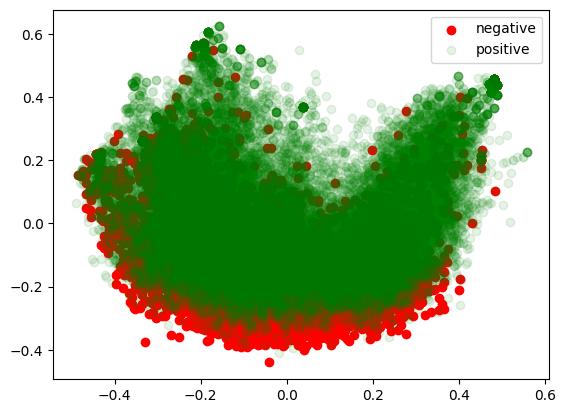

In [ ]:
plt.scatter(negative[:, 0], negative[:, 1], color='red', label='negative')
plt.scatter(positive[:, 0], positive[:, 1], color='green', alpha=0.1, label='positive')
plt.legend();

## Обратная связь
- [ ] Хочу получить обратную связь по решению